In [35]:
# This notebook is derived from Qiskit and includes modifications by qBraid.
#
# (C) Copyright IBM 2020.
# (C) Copyright qBraid 2025.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

# qBraid-SDK Qiskit on AWS Device Demo: Bernstein-Vazirani Algorithm

In [1]:
import qbraid

qbraid.__version__

'0.9.7.dev20250513230510'

## Creating the Circuit

The code for this circuit was taken from IBMs Bernstein-Vazirani algorithm tutorial. Check out their [tutorial](https://www.youtube.com/watch?v=sqJIpHYl7oo) for a more in depth explanation. Classically, it takes $n$ queries to decipher a secret string of length $n$ – the Bernstein-Vazirani algorithm allows us to develop an oracle in a quantum circuit that is able to guess the string with just one query!

In [2]:
from qiskit import QuantumCircuit

In [33]:
s = "110000"  # the number we hope to guess
n = len(s)

qiskit_circuit = QuantumCircuit(n + 1)

qiskit_circuit.x(n)
qiskit_circuit.barrier()
qiskit_circuit.h(range(n + 1))
qiskit_circuit.barrier()

for ii, yesno in enumerate(s):
    if yesno == "1":
        qiskit_circuit.cx(ii, n)

qiskit_circuit.barrier()
qiskit_circuit.h(range(n + 1))
qiskit_circuit.barrier()
qiskit_circuit.measure_all()

In [34]:
from qbraid.visualization import circuit_drawer

circuit_drawer(qiskit_circuit)  # Visualizing the circuit

░ ┌───┐ ░            ░ ┌───┐ ░  ░ ┌─┐                  
   q_0: ──────░─┤ H ├─░───■────────░─┤ H ├─░──░─┤M├──────────────────
              ░ ├───┤ ░   │        ░ ├───┤ ░  ░ └╥┘┌─┐               
   q_1: ──────░─┤ H ├─░───┼────■───░─┤ H ├─░──░──╫─┤M├───────────────
              ░ ├───┤ ░   │    │   ░ ├───┤ ░  ░  ║ └╥┘┌─┐            
   q_2: ──────░─┤ H ├─░───┼────┼───░─┤ H ├─░──░──╫──╫─┤M├────────────
              ░ ├───┤ ░   │    │   ░ ├───┤ ░  ░  ║  ║ └╥┘┌─┐         
   q_3: ──────░─┤ H ├─░───┼────┼───░─┤ H ├─░──░──╫──╫──╫─┤M├─────────
              ░ ├───┤ ░   │    │   ░ ├───┤ ░  ░  ║  ║  ║ └╥┘┌─┐      
   q_4: ──────░─┤ H ├─░───┼────┼───░─┤ H ├─░──░──╫──╫──╫──╫─┤M├──────
              ░ ├───┤ ░   │    │   ░ ├───┤ ░  ░  ║  ║  ║  ║ └╥┘┌─┐   
   q_5: ──────░─┤ H ├─░───┼────┼───░─┤ H ├─░──░──╫──╫──╫──╫──╫─┤M├───
        ┌───┐ ░ ├───┤ ░ ┌─┴─┐┌─┴─┐ ░ ├───┤ ░  ░  ║  ║  ║  ║  ║ └╥┘┌─┐
   q_6: ┤ X ├─░─┤ H ├─░─┤ X ├┤ X ├─░─┤ H ├─░──░──╫──╫──╫──╫──╫──╫─┤M├
        └───┘ ░ └───┘ ░ └───┘└───┘ ░ └───┘ ░  ░  ║  ║  ║  ║  ║  ║ └╥┘
meas: 7/═════════════════════════════════════════╩══╩══╩══╩══╩══╩══╩═
                                                 0  1  2  3  4  5  6

## Running on an AWS Device via qBraid

Let's check which devices are online, and also find their device IDs:

In [35]:
from qbraid.runtime import QbraidProvider

In [36]:
provider = QbraidProvider()
provider.get_devices()

[<qbraid.runtime.native.device.QbraidDevice('aws_sv1')>,
 <qbraid.runtime.native.device.QbraidDevice('aws_tn1')>,
 <qbraid.runtime.native.device.QbraidDevice('quera_aquila')>,
 <qbraid.runtime.native.device.QbraidDevice('aws_dm1')>,
 <qbraid.runtime.native.device.QbraidDevice('qbraid_qir_simulator')>,
 <qbraid.runtime.native.device.QbraidDevice('iqm_garnet')>,
 <qbraid.runtime.native.device.QbraidDevice('quera_qasm_simulator')>,
 <qbraid.runtime.native.device.QbraidDevice('ionq_simulator')>,
 <qbraid.runtime.native.device.QbraidDevice('nec_vector_annealer')>,
 <qbraid.runtime.native.device.QbraidDevice('ionq_aria_1')>,
 <qbraid.runtime.native.device.QbraidDevice('rigetti_ankaa_3')>]

In this tutorial we'll use Amazon's SV1 simulator, since we see that it's online. Now we can use the `QbraidProvider` run a job on an Amazon device. The device wrapper adds a layer of abstraction, allowing us to run a qiskit circuit on an AWS quantum computer. Note that there's no need for any sort of circuit wrapper here – we can plug the qiskit circuit directly into the wrapped device!

In [37]:
aws_device_id = "aws_sv1"
device = provider.get_device(aws_device_id)
device

<qbraid.runtime.native.device.QbraidDevice('aws_sv1')>

In [38]:
braket_job = device.run(qiskit_circuit, shots=100)
braket_job.status()

<INITIALIZING: 'job is being initialized'>

In [39]:
result = braket_job.result()
counts = result.data.measurement_counts
print(counts)

{'1100001': 100}


In [40]:
result

Result(
  device_id=aws_sv1,
  job_id=aws_sv1-harshit-qjob-s5fezhgfhayaof7qm6hh,
  success=True,
  data=GateModelResultData(measurement_counts={'1100001': 100}, measurements=array(shape=(0,), dtype=object)),
  status='COMPLETED',
  statusText='job has successfully run',
  shots=100,
  experimentType=GATE_MODEL,
  queuePosition=None,
  timeStamps={createdAt: 2025-07-07T08:32:36Z, endedAt: 2025-07-07T08:32:37Z, executionDuration: 2},
  tags={},
  cost=Credits('0.375'),
  preflight=False,
  schemaHeader={name: 'qbraid.runtime.schemas.job', version: 1.0},
  metadata={openQasm: '...', circuitNumQubits: 7, circuitDepth: 6}
)

#### NOTE 
The last bit of the result is just the **output bit**. The number is composed of the first 6 bits i.e. $\mathbf{110000}$

In [41]:
from qbraid.visualization import plot_histogram

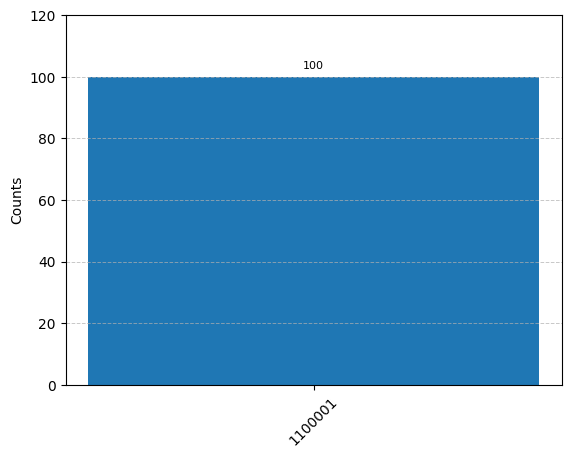

In [42]:
plot_histogram(counts)

We have guessed the number correctly! Note the bar graph where only one number was guessed in all 100 shots